In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import contractions
import string
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime, timedelta

In [3]:
def read_data1(path, location, event_type, start_date, end_date):
    #df_train
    df_train = pd.read_csv(path + 'train.tsv', delimiter='\t')
    df_train['location'] = location
    df_train['type'] = event_type
    df_train.drop('tweet_id', axis=1, inplace = True)
    df_train['target'] = 0
    df_train.loc[df_train['class_label'].isin(['displaced_people_and_evacuations','caution_and_advice','infrastructure_and_utility_damage','requests_or_urgent_needs']), 'target'] = 1
    df_train.drop('class_label', axis=1, inplace = True)
    time_frame = end_date - start_date # total time frame in days

    random_datetimes = [start_date + timedelta(days=random.randrange(time_frame.days), 
                                                 hours=random.randint(0, 23),
                                                 minutes=random.randint(0, 59),
                                                 seconds=random.randint(0, 59)) for i in range(len(df_train))]
    df_train['datetime'] = random_datetimes
    df_train['year'] = [d.year for d in df_train['datetime']]
    df_train['date'] = [d.date() for d in df_train['datetime']]
    df_train['time'] = [d.time() for d in df_train['datetime']]

    #df_test
    df_test = pd.read_csv(path + 'test.tsv', delimiter='\t')
    df_test['location'] = location
    df_test['type'] = event_type
    df_test.drop('tweet_id', axis=1, inplace = True)
    df_test['target'] = 0
    df_test.loc[df_test['class_label'].isin(['displaced_people_and_evacuations','caution_and_advice','infrastructure_and_utility_damage','requests_or_urgent_needs']), 'target'] = 1
    df_test.drop('class_label', axis=1, inplace = True)
    time_frame = end_date - start_date # total time frame in days

    random_datetimes = [start_date + timedelta(days=random.randrange(time_frame.days), 
                                                 hours=random.randint(0, 23),
                                                 minutes=random.randint(0, 59),
                                                 seconds=random.randint(0, 59)) for i in range(len(df_test))]
    df_test['datetime'] = random_datetimes
    df_test['year'] = [d.year for d in df_test['datetime']]
    df_test['date'] = [d.date() for d in df_test['datetime']]
    df_test['time'] = [d.time() for d in df_test['datetime']]

    #df_dev
    df_dev = pd.read_csv(path + 'dev.tsv', delimiter='\t')
    df_dev['location'] = location
    df_dev['type'] = event_type
    df_dev.drop('tweet_id', axis=1, inplace = True)
    df_dev['target'] = 0
    df_dev.loc[df_dev['class_label'].isin(['displaced_people_and_evacuations','caution_and_advice','infrastructure_and_utility_damage','requests_or_urgent_needs']), 'target'] = 1
    df_dev.drop('class_label', axis=1, inplace = True)
    time_frame = end_date - start_date # total time frame in days

    random_datetimes = [start_date + timedelta(days=random.randrange(time_frame.days), 
                                                 hours=random.randint(0, 23),
                                                 minutes=random.randint(0, 59),
                                                 seconds=random.randint(0, 59)) for i in range(len(df_dev))]
    df_dev['datetime'] = random_datetimes
    df_dev['year'] = [d.year for d in df_dev['datetime']]
    df_dev['date'] = [d.date() for d in df_dev['datetime']]
    df_dev['time'] = [d.time() for d in df_dev['datetime']]
    return df_train, df_test, df_dev

In [4]:
events = [{'path': '/DSCI560/project/events_set1/canada_wildfires_2016/canada_wildfires_2016_', 'location': 'Canada', 'event_type': 'wildfire', 'start_date': datetime(2016, 4, 30), 'end_date': datetime(2016, 6, 1)},
          {'path': '/DSCI560/project/events_set1/cyclone_idai_2019/cyclone_idai_2019_', 'location': 'Zimbabwe', 'event_type': 'cyclone', 'start_date': datetime(2019, 3, 4), 'end_date': datetime(2019, 3, 21)},
          {'path': '/DSCI560/project/events_set1/ecuador_earthquake_2016/ecuador_earthquake_2016_', 'location': 'Ecuador', 'event_type': 'earthquake', 'start_date': datetime(2016, 4, 16), 'end_date': datetime(2016, 4, 17)},
          {'path': '/DSCI560/project/events_set1/greece_wildfires_2018/greece_wildfires_2018_', 'location': 'Greece', 'event_type': 'wildfire', 'start_date': datetime(2018, 7, 23), 'end_date': datetime(2018, 7, 26)},
          {'path': '/DSCI560/project/events_set1/hurricane_harvey_2017/hurricane_harvey_2017_', 'location': 'Texas, USA', 'event_type': 'hurricane', 'start_date': datetime(2017, 8, 17), 'end_date': datetime(2017, 9, 3)},
          {'path': '/DSCI560/project/events_set1/hurricane_irma_2017/hurricane_irma_2017_', 'location': 'Florida, USA', 'event_type': 'hurricane', 'start_date': datetime(2017, 8, 30), 'end_date': datetime(2017, 9, 13)},
          {'path': '/DSCI560/project/events_set1/hurricane_maria_2017/hurricane_maria_2017_', 'location': 'Puerto Rico', 'event_type': 'hurricane', 'start_date': datetime(2017, 9, 16), 'end_date': datetime(2017, 10, 2)},
          {'path': '/DSCI560/project/events_set1/hurricane_matthew_2016/hurricane_matthew_2016_', 'location': 'Haiti', 'event_type': 'hurricane', 'start_date': datetime(2016, 9, 28), 'end_date': datetime(2016, 10, 10)},
          {'path': '/DSCI560/project/events_set1/italy_earthquake_aug_2016/italy_earthquake_aug_2016_', 'location': 'Italy', 'event_type': 'earthquake', 'start_date': datetime(2016, 8, 24), 'end_date': datetime(2016, 10, 30)},
          {'path': '/DSCI560/project/events_set1/kaikoura_earthquake_2016/kaikoura_earthquake_2016_', 'location': 'New Zealand', 'event_type': 'earthquake', 'start_date': datetime(2016, 11, 14), 'end_date': datetime(2016, 11, 15)},
          {'path': '/DSCI560/project/events_set1/maryland_floods_2018/maryland_floods_2018_', 'location': 'Maryland, USA', 'event_type': 'flood', 'start_date': datetime(2018, 5, 27), 'end_date': datetime(2018, 5, 28)},         
          {'path': '/DSCI560/project/events_set1/puebla_mexico_earthquake_2017/puebla_mexico_earthquake_2017_', 'location': 'Mexico', 'event_type': 'earthquake', 'start_date': datetime(2017, 9, 19), 'end_date': datetime(2017, 9, 20)},
          {'path': '/DSCI560/project/events_set1/srilanka_floods_2017/srilanka_floods_2017_', 'location': 'Srilanka', 'event_type': 'flood', 'start_date': datetime(2017, 5, 28), 'end_date': datetime(2017, 6, 1)}]

dfs_train1 = []
dfs_test1 = []
dfs_dev1 = []

for event in events:
    path = event['path']
    location = event['location']
    event_type = event['event_type']
    start_date = event['start_date']
    end_date = event['end_date']
    
    df_train1, df_test1, df_dev1 = read_data1(path, location, event_type, start_date, end_date)
    
    dfs_train1.append(df_train1)
    dfs_test1.append(df_test1)
    dfs_dev1.append(df_dev1)

df_train1 = pd.concat(dfs_train1)
df_test1 = pd.concat(dfs_test1)
df_dev1 = pd.concat(dfs_dev1)

In [5]:
df_train1

,tweet_text,location,type,target,datetime,year,date,time
0,RT @DonBradshawNTV: How @MarshallAmpsUK came t...,Canada,wildfire,0,2016-05-06 16:54:00,2016,2016-05-06,16:54:00
1,Red Cross distributes $30M to Fort McMurray wi...,Canada,wildfire,1,2016-05-30 17:30:57,2016,2016-05-30,17:30:57
2,Interesting insights on the shifting communica...,Canada,wildfire,0,2016-04-30 23:18:34,2016,2016-04-30,23:18:34
3,RT @globeandmail: Oil sands producers helping ...,Canada,wildfire,0,2016-05-30 08:00:05,2016,2016-05-30,08:00:05
4,Ottawa to match Red Cross donations for Fort M...,Canada,wildfire,0,2016-05-06 21:06:11,2016,2016-05-06,21:06:11
...,...,...,...,...,...,...,...,...
387,"South Korean Actress Lee Young-ae, ‘Changumi’ ...",Srilanka,flood,0,2017-05-29 01:03:57,2017,2017-05-29,01:03:57
388,Flood donations granted under North-South Brot...,Srilanka,flood,0,2017-05-28 10:56:28,2017,2017-05-28,10:56:28
389,#Inspiring Naval diving teams rescue a dog whi...,Srilanka,flood,0,2017-05-31 13:36:42,2017,2017-05-31,13:36:42
390,Norway to provide US$ 1.2 million to Sri Lanka...,Srilanka,flood,0,2017-05-30 16:05:12,2017,2017-05-30,16:05:12


In [6]:
def read_data2(df, event_type):
    df = pd.read_csv(df, delimiter='\t')
#     df = df.dropna()
    df['type'] = event_type
    df['tweet_text'] = df['text']
    df['datetime'] = pd.to_datetime(df['created_at'])
    df['date'] = df['datetime'].dt.date
    df['year'] = df['datetime'].dt.year.fillna(0).astype(int)
    df['time'] = df['datetime'].dt.time
    df['target'] = 0
    df.loc[df['label'].isin(['direct-eyewitness','indirect-eyewitness']), 'target'] = 1
    df = df[['tweet_text', 'location', 'type','target', 'datetime','year','date','time']].dropna()

    return df

In [7]:
events = [{'path': '/DSCI560/project/eyewitness_tweets_annotations_14k_public/labeled_by_authors/earthquakes_eyewitness_annotations_2000.tsv','event_type': 'earthquake'},
          {'path': '/DSCI560/project/eyewitness_tweets_annotations_14k_public/labeled_by_authors/floods_eyewitness_annotations_2000.tsv','event_type': 'flood'},
          {'path': '/DSCI560/project/eyewitness_tweets_annotations_14k_public/labeled_by_authors/hurricanes_eyewitness_annotations_2004.tsv', 'event_type': 'hurricane'}]
          
dfs2 = []

for event in events:
    path = event['path']
    event_type = event['event_type']
    
    df2 = read_data2(path, event_type)
    
    dfs2.append(df2)

df2 = pd.concat(dfs2)

In [8]:
df2

,tweet_text,location,type,target,datetime,year,date,time
0,#earthquake Magnitude 2.1 occurred 159km NE of...,Italia,earthquake,0,2017-08-01 08:12:42+00:00,2017,2017-08-01,08:12:42
1,Retweeted Earthquakes Tsunamis (@NewEarthquake...,Malaysia,earthquake,0,2017-08-01 08:13:08+00:00,2017,2017-08-01,08:13:08
2,I always know I need to go shopping when I've ...,"Hollywood, California, USA..... planet earth",earthquake,0,2017-08-01 08:13:15+00:00,2017,2017-08-01,08:13:15
3,Update: M2.0 #earthquake (#sismo) strikes 1 km...,"BruyÃ¨res-Le-Chatel, France",earthquake,0,2017-08-01 08:13:48+00:00,2017,2017-08-01,08:13:48
4,ã€,With everyone,earthquake,0,2017-08-01 08:14:58+00:00,2017,2017-08-01,08:14:58
...,...,...,...,...,...,...,...,...
1991,Prayers going up all the way from TN for all t...,"Clarksville, TN",hurricane,0,2017-08-26 12:41:08+00:00,2017,2017-08-26,12:41:08
1992,If the Flash Flood Warning sound was a person ...,"Houston, TX",hurricane,0,2017-08-26 12:45:50+00:00,2017,2017-08-26,12:45:50
1993,Dear Texans: don't drive into flood waters #hu...,"Northeast US, Earth",hurricane,0,2017-08-26 12:48:39+00:00,2017,2017-08-26,12:48:39
1994,Story featuring hurricane expert Hal Needham. ...,"Columbia, SC",hurricane,0,2017-08-26 12:53:57+00:00,2017,2017-08-26,12:53:57


In [9]:
df_train2, df_test2 = train_test_split(df2, test_size=0.2, shuffle=True, random_state=42)

In [10]:
df_train2, df_dev2 = train_test_split(df_train2, test_size=0.1, shuffle=True, random_state=42)

In [11]:
df_train = pd.concat([df_train1, df_train2])
df_test = pd.concat([df_test1, df_test2])
df_dev = pd.concat([df_dev1, df_dev2])

In [12]:
df_train.shape

(33537, 8)

In [13]:
df_test.shape

(9483, 8)

In [14]:
df_dev.shape

(4773, 8)

In [15]:
df_all = pd.concat([df_train, df_test, df_dev])

In [16]:
df_all.shape

(47793, 8)

In [17]:
# check if there is any NaN value
print(df_all.isna().sum())

tweet_text    0
location      0
type          0
target        0
datetime      0
year          0
date          0
time          0
dtype: int64


In [18]:
df_all = df_all.groupby('location').filter(lambda x: len(x) >= 8)
df_all.shape

(44499, 8)

In [19]:
count = len(df_all[df_all['location'] == 'United States'])
print(count)

72


In [20]:
most_common_location = df_all['location'].value_counts().idxmax()
print(most_common_location)
# Replace NaN values with the most common location
# df['location'] = df_all['location'].fillna(most_common_location)

Florida, USA


In [21]:
unique_locations = df_all['location'].unique()
print(len(unique_locations))

70


In [22]:
# import csv
# with open('unique_locations.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     for item in unique_locations:
#         writer.writerow([item])

In [23]:
path = "/DSCI560/unique_locations0.csv"

# read the file into a pandas dataframe
df_name = pd.read_csv(path,names=['name', 'correction'])
df_name.astype(str)

,name,correction
0,Canada,Canada
1,Zimbabwe,Zimbabwe
2,Ecuador,Ecuador
3,Greece,Greece
4,"Texas, USA","Texas, USA"
...,...,...
65,"New York, USA","New York, USA"
66,Republic of the Philippines,Republic of the Philippines
67,"England, United Kingdom",United Kingdom
68,United Kingdom,United Kingdom


In [24]:
df_all['location'] = df_all['location'].astype(str)

In [25]:
df_all.dtypes

tweet_text    object
location      object
type          object
target         int64
datetime      object
year           int64
date          object
time          object
dtype: object

In [26]:
df_all.shape

(44499, 8)

In [27]:
df_train.shape

(33537, 8)

In [28]:
df_test.shape

(9483, 8)

In [29]:
df_dev.shape

(4773, 8)

In [30]:
df_all_final = df_all.merge(df_name, left_on='location', right_on='name', how='left')
df_all_final.dropna(inplace=True)
df_all_final.drop(['name', 'correction'], axis=1, inplace= True)
df_all_final.shape

(44499, 8)

In [31]:
df_train_final = df_train.merge(df_name, left_on='location', right_on='name', how='left')
df_train_final.dropna(inplace=True)
df_train_final.drop(['name', 'correction'], axis=1, inplace= True)
df_train_final.shape

(31186, 8)

In [32]:
df_test_final = df_test.merge(df_name, left_on='location', right_on='name', how='left')
df_test_final.dropna(inplace=True)
df_test_final.drop(['name', 'correction'], axis=1, inplace= True)
df_test_final.shape

(8810, 8)

In [33]:
df_dev_final = df_dev.merge(df_name, left_on='location', right_on='name', how='left')
df_dev_final.dropna(inplace=True)
df_dev_final.drop(['name', 'correction'], axis=1, inplace= True)
df_dev_final.shape

(4503, 8)

Top 10 most common words in all tweets:
to: 23587
the: 21450
in: 18173
of: 15184
and: 12449
for: 9746
Hurricane: 8288
RT: 8035
a: 7707
is: 6608


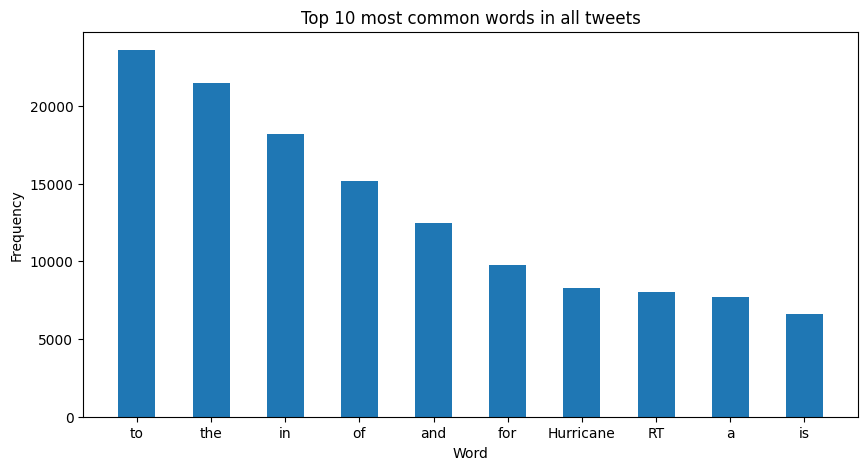

In [34]:
from collections import Counter

all_tweets = ' '.join(df_all_final['tweet_text'])
words = all_tweets.split()
# Count the frequency of each word
word_counts = Counter(words)

# Get the top 10 most common words
top_words = word_counts.most_common(10)

# Print the top 10 most common words
print("Top 10 most common words in all tweets:")
for word, count in top_words:
    print(f"{word}: {count}")

# Extract the top words and their frequencies
top_word_freqs = [count for word, count in top_words]
top_words = [word for word, count in top_words]

# Create a bar plot of the top 10 most common words
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(top_words, top_word_freqs, width=0.5)
ax.set_xlabel('Word')
ax.set_ylabel('Frequency')
ax.set_title('Top 10 most common words in all tweets')
plt.show()

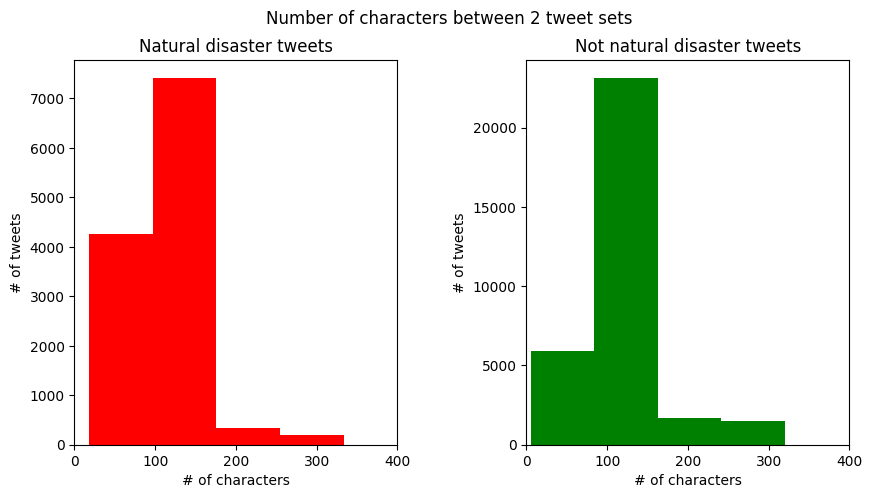

In [35]:
# Number of characters in tweets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.4, 'hspace': 0.4})
tweet_len = df_all_final[df_all_final['target']==1]['tweet_text'].str.len()
ax1.hist(tweet_len, color='red')
ax1.set_title('Natural disaster tweets')
ax1.set_ylabel('# of tweets')
ax1.set_xlabel('# of characters')

ax1.set_xlim([0, 400])

tweet_len = df_all_final[df_all_final['target']==0]['tweet_text'].str.len()
ax2.hist(tweet_len, color='green')
ax2.set_title('Not natural disaster tweets')
ax2.set_ylabel('# of tweets')
ax2.set_xlim([0, 400])
ax2.set_xlabel('# of characters')


fig.suptitle('Number of characters between 2 tweet sets')
plt.show()


## Data cleaning & Preprocessing

In [36]:
dataframes_list = [df_all_final, df_train_final, df_test_final, df_dev_final]
stopwords_english = stopwords.words('english')

for df in dataframes_list:
    # convert to lower case
    df['tweet_text'] = df['tweet_text'].str.lower()
    
    # remove the HTML and URLs from the reviews (ref: https://stackoverflow.com/questions/45999415/removing-html-tags-in-pandas)
    df['tweet_text'] = df['tweet_text'].str.replace(r'<[^<>]*>', '', regex=True)
    
    # remove non-alphabetical characters and punctuations from all tweets.
    # print(string.punctuation)
    df['tweet_text'] = df['tweet_text'].str.replace('[^a-zA-Z]', ' ').replace('[{}]'.format(string.punctuation), '')
    
    # remove extra spaces from all reviews.
    df['tweet_text'] = df['tweet_text'].str.strip()

    # perform contractions on the reviews by using the package contractions (ref: https://www.dataquest.io/blog/how-to-clean-and-prepare-your-data-for-analysis/).
    df['tweet_text'] = df['tweet_text'].astype(str).apply(lambda x: contractions.fix(x))
    
    #remove the stop words (ref: https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe)
    df['tweet_text'] = df['tweet_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords_english)]))

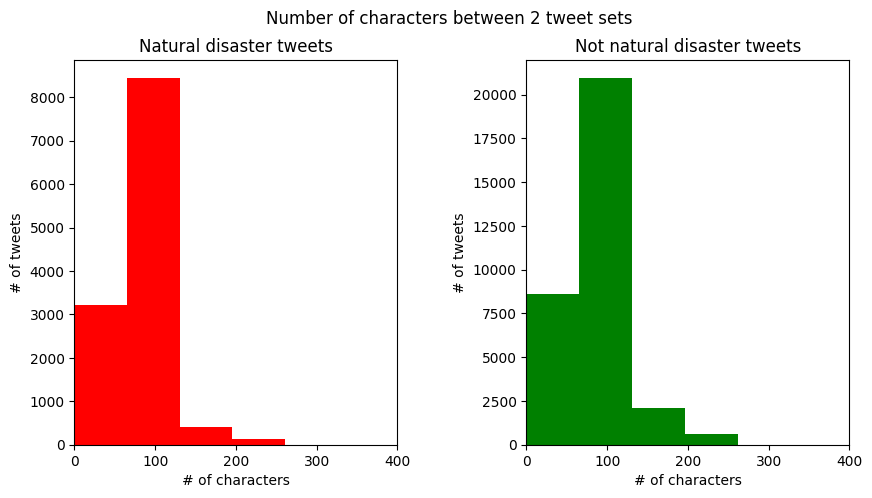

In [44]:
# Number of characters in tweets
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'wspace': 0.4, 'hspace': 0.4})
tweet_len = df_all_final[df_all_final['target']==1]['tweet_text'].str.len()
ax1.hist(tweet_len, color='red')
ax1.set_title('Natural disaster tweets')
ax1.set_ylabel('# of tweets')
ax1.set_xlabel('# of characters')

ax1.set_xlim([0, 400])

tweet_len = df_all_final[df_all_final['target']==0]['tweet_text'].str.len()
ax2.hist(tweet_len, color='green')
ax2.set_title('Not natural disaster tweets')
ax2.set_ylabel('# of tweets')
ax2.set_xlim([0, 400])
ax2.set_xlabel('# of characters')


fig.suptitle('Number of characters between 2 tweet sets')
plt.show()

Top 10 most common words in all tweets:
hurricane: 10708
harvey: 6527
help: 6183
irma: 5706
amp: 4596
people: 4387
relief: 3883
damage: 3616
victims: 3611
affected: 3405


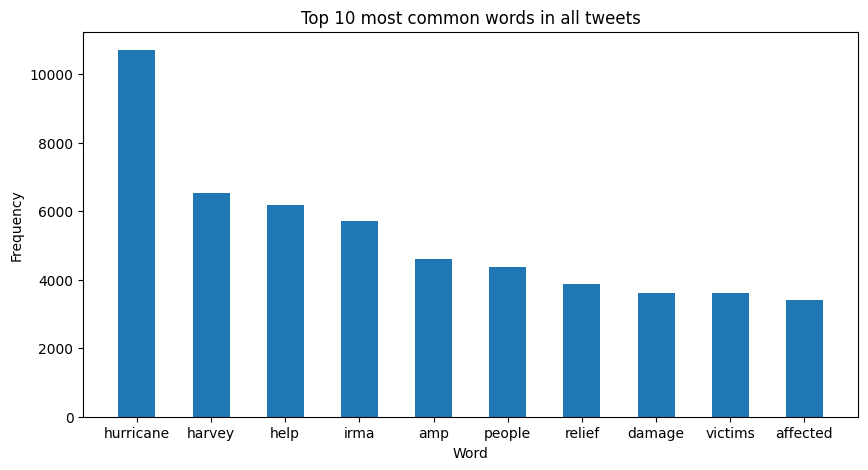

In [45]:
from collections import Counter

all_tweets = ' '.join(df_all_final['tweet_text'])
words = all_tweets.split()
# Count the frequency of each word
word_counts = Counter(words)

# Get the top 10 most common words
top_words = word_counts.most_common(10)

# Print the top 10 most common words
print("Top 10 most common words in all tweets:")
for word, count in top_words:
    print(f"{word}: {count}")

# Extract the top words and their frequencies
top_word_freqs = [count for word, count in top_words]
top_words = [word for word, count in top_words]

# Create a bar plot of the top 10 most common words
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(top_words, top_word_freqs, width=0.5)
ax.set_xlabel('Word')
ax.set_ylabel('Frequency')
ax.set_title('Top 10 most common words in all tweets')
plt.show()

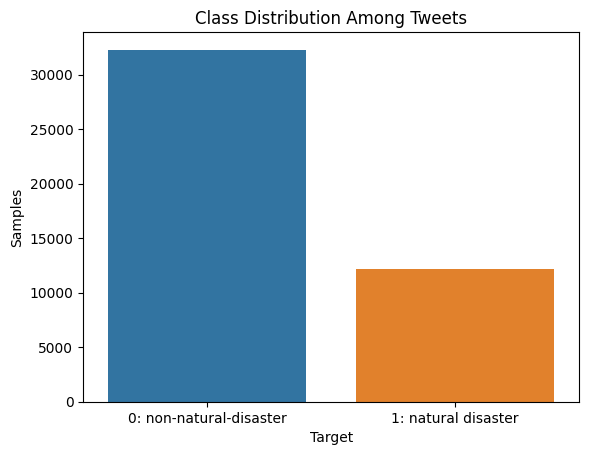

In [46]:
x=df_all['target'].value_counts()
ax = sns.barplot(x=x.index, y=x)
ax.set_xlabel('Target')
ax.set_ylabel('Samples')
ax.set_title('Class Distribution Among Tweets')
ax.set_xticklabels(['0: non-natural-disaster', '1: natural disaster'])
plt.show()

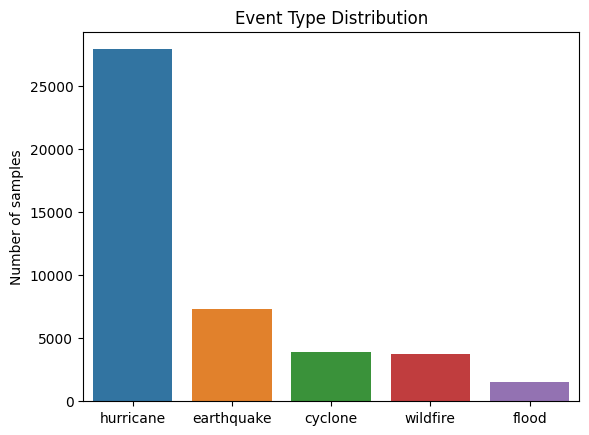

In [47]:
x=df_all['type'].value_counts()
ax = sns.barplot(x=x.index, y=x)
# ax.set_xlabel('Event Type')
ax.set_ylabel('Number of samples')
ax.set_title('Event Type Distribution')
# ax.set_xticklabels(['Not Natural Disaster', 'Natural Disaster'])
plt.show()

In [49]:
df_all_final.to_csv('all.csv', index=False)
df_train_final.to_csv('train.csv', index=False)
df_test_final.to_csv('test.csv', index=False)
df_dev_final.to_csv('val.csv', index=False)